# GeoJson 2 COCO

## Import

In [28]:
import argparse
import json
import pandas as pd
import rasterio as rio
import rioxarray as rxr
import geopandas as gpd
import geoplot
import os
import matplotlib.pyplot as plt
from rasterio import plot as rasterplot
from shapely.geometry import Polygon, mapping, MultiPoint
import fiona.transform
from itertools import product
from rasterio import windows


In [2]:
def wkt_parser(wkt_str:str):
    wkt = wkt_str.split('"')
    set = False
    for x in wkt:
        if set is True:
            return x
        if x == "LOCAL_CS[":
            set = True
    return wkt_str
    
def reproject_coords(src_crs, dst_crs, coords):
    xs = [c[0] for c in coords]
    ys = [c[1] for c in coords]
    xs, ys = fiona.transform.transform(src_crs, dst_crs, xs, ys)
    return [[x,y] for x,y in zip(xs, ys)]

## Read Data

In [3]:
raster_path = os.path.join(os.path.expanduser("~"),"Data/GIS2COCO/sentinel2_clip.tif") # sentinel2_clip has wrong meta data (i.e. bounds are wrong)
geojson_path = os.path.join(os.path.expanduser("~"),"Data/GIS2COCO/nsw_landuse.geojson")

### Read GeoJson

In [4]:
geojson = gpd.read_file(geojson_path)
geojson_crs = geojson.crs
print(geojson_crs)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [ ]:
geoplot.polyplot(geojson, projection=geoplot.crs.AlbersEqualArea(), edgecolor='darkgrey', facecolor='lightgrey', linewidth=.3,
    figsize=(8, 12))

### Read raster

In [5]:
geotiff = rio.open(raster_path) # , crs='EPSG:4326'
raster = geotiff.read(1)

In [6]:
geotiff_crs = geotiff.crs.to_wkt()
geotiff_crs = wkt_parser(geotiff_crs)
print(geotiff_crs)

GDA94 / Australian Albers


In [ ]:
plt.imshow(geotiff.read(1))

### Transform CRS

#### Raster to GeoJson
WIP: do not run

In [ ]:
# DO NOT RUN THIS
crs = rasterio.crs.CRS({"init": "epsg:4326"})    # or whatever CRS you know the image is in    
with rasterio.open('/path/to/file.tif', mode='r+') as src:
    src.transform = transform
    src.crs = crs

In [ ]:
geotiff_rxr = rxr.open_rasterio(raster_path,masked=True).squeeze()
geotiff_rxr.rio.crs
# geotiff_rxr_reprojected = geotiff_rxr.rio.reproject(crs)

In [ ]:
geotiff_rxr.plot(cmap="Greys_r")geotiff_rxr.plot(cmap="Greys_r")geotiff_rxr.plot(cmap="Greys_r")

In [ ]:
f, ax = plt.subplots()

# plot raster
geotiff_rxr.plot(cmap="Greys_r",
    extent=[geotiff_rxr.rio.bounds()[0], geotiff_rxr.rio.bounds()[2], geotiff_rxr.rio.bounds()[1], geotiff_rxr.rio.bounds()[3]],
    ax=ax,
)

# plot shapefiles
geojson.plot(ax=ax, facecolor='w', edgecolor='b', alpha=0.5)
#plt.savefig('small_test_4326.jpg')
plt.show()

#### GeoJson to Raster

In [7]:
geojson_t = geojson.to_crs(geotiff_crs)

### Visualise

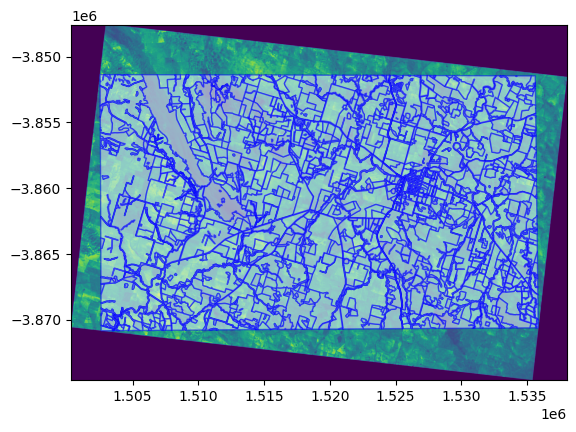

In [8]:
f, ax = plt.subplots()

# plot raster
rio.plot.show(
    geotiff.read(1),  # use tiff.read(1) with your data
    extent=[geotiff.bounds[0], geotiff.bounds[2], geotiff.bounds[1], geotiff.bounds[3]],
    ax=ax,
)

# plot shapefiles
geojson_t.plot(ax=ax, facecolor='w', edgecolor='b', alpha=0.5)
#plt.savefig('small_test_4326.jpg')
plt.show()

In [9]:
print("bounds:",geotiff.bounds)

bounds: BoundingBox(left=1500314.0794, bottom=-3874596.8554, right=1538038.6909, top=-3847595.4442)


### Spatial to Pixel

#### GDAL method

In [ ]:
from osgeo import osr, ogr, gdal

def spatial_to_pixel_gdal(geo_matrix, x, y):
    """
    Uses a gdal geomatrix (gdal.GetGeoTransform()) to calculate
    the pixel location of a geospatial coordinate
    """
    ul_x= geo_matrix[0]
    ul_y = geo_matrix[3]
    x_dist = geo_matrix[1]
    y_dist = geo_matrix[5]
    pixel = int((x - ul_x) / x_dist)
    line = -int((ul_y - y) / y_dist)
    return pixel, line

ds = gdal.Open(raster_path)
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(1510314.0794,-3864596.8554)

x, y = spatial_to_pixel_gdal(ds.GetGeoTransform(), point.GetX(), point.GetY())
print(x, y)

#### RIO method

In [10]:
def spatial_to_pixel_rio(raster, x, y):
    """
    x: lon
    y: lat
    """
    px,py = raster.index(x,y) # lon,lat
    return px,py

# reprojected_coords = fiona.transform.transform("EPSG:4326","EPSG:3577",[148.466743],[-34.402774])
x,y = spatial_to_pixel_rio(geotiff,1510314.0794,-3864596.8554)
print(x, y)

1922 905


In [11]:
def pixel_to_spatial_rio(raster,x,y):
    """
    
    """
    return raster.xy(x,y)  #px, py
    
pixel_to_spatial_rio(geotiff, x, y)

(1510311.046246137, -3864598.461898002)

### Polygon to pixel

#### GDAL method

In [ ]:
def spatial_polygon_to_pixel(raster_tile, spatial_polygon):
    raster = gdal.Open(raster_tile)
    point_list = MultiPoint(spatial_polygon.exterior.coords)
    converted_coords = []
    for point in point_list:
        x, y = spatial_to_pixel(raster.GetGeoTransform(), point.x, point.y)
        pixel_point = x, y
        converted_coords.append(pixel_point)
    return(converted_coords)

#### RIO method

In [12]:
def spatial_polygon_to_pixel_rio(raster, polygon):    
    converted_coords = []
    for point in list(MultiPoint(polygon.exterior.coords).geoms):
        x, y = spatial_to_pixel_rio(raster, point.x, point.y)
        pixel_point = x, y
        converted_coords.append(pixel_point)
    return(converted_coords)


for index, polygon in enumerate(geojson_t.geometry):
    pass
print(index,'\n',MultiPoint(polygon.exterior.coords),'\n\n\n\n')

In [13]:
geotiff

<open DatasetReader name='/home/sahand/Data/GIS2COCO/sentinel2_clip.tif' mode='r'>

## COCO Annotation

In [14]:
print(geotiff.shape)
print(geotiff.count)
geotiff.dtypes[0]

(3053, 3417)
1


'uint16'

#### TIFF to PNG

In [15]:
class coco_json: 
    def toJSON(self):
        return(json.dumps(self, default=lambda o: o.__dict__, indent = 4))
    
    class coco_image: 
        pass
    
    class coco_images: 
        pass
        
    class coco_poly_ann: 
        pass
    
    class coco_poly_anns: 
        pass
    

In [16]:
def get_tiles(raster, width=2000, height=2000, map_units=False):

    """
    Defines a set of tiles over a raster layer based on user specified dimensions.

    Args:
        raster: a raster layer that has been read into memory
        width: integer defining the width of tiles
        length: integer defining the length of tiles
        map_units: boolean specifying if width and height are in map unit, or in pixels (default)
    """

    if map_units:
        if raster.transform.b==raster.transform.d==0:
        # Get pixel size (x is width) (https://gis.stackexchange.com/questions/379005/using-raster-transform-function-of-rasterio-in-python)
            cell_x, _ = raster.transform.a, -raster.transform.e 
            width, height = int(width / cell_x + 0.5) , int(height / cell_x + 0.5)
        else:
            raise ValueError("Coefficient a from raster.transform.a is not width.")

    ncols, nrows = raster.meta['width'], raster.meta['height']

    offsets = product(range(0, ncols, width), range(0, nrows, height)) # Not actual offsets, but just a grid of cells
    big_window = windows.Window(col_off=0, row_off=0, width=ncols, height=nrows)

    for col_off, row_off in  offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, raster.transform)
        yield window, transform

def write_raster_tiles(infile, out_path):

    output_filename = "tile_{}-{}.tif"

    with rio.open(infile) as inds:
    
        tile_width, tile_height = 2000, 2000  

        meta = inds.meta.copy()

        for window, transform in get_tiles(inds, tile_width, tile_height, map_units=True):

            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            outpath = os.path.join(out_path,output_filename.format(int(window.col_off), int(window.row_off)))
            with rio.open(outpath, 'w', **meta) as outds:
                outds.write(inds.read(window=window))

def get_tile_polygons(raster_tile, geojson, project_crs = "EPSG:3577", filter = True):
    """
    Create polygons from a geosjon for an individual raster tile.
    
    Args:
        raster_tile: a file name referring to the raster tile to be loaded
        geojson: a geodataframe with polygons
        
    Returns: 
        tile_polygon: geodataframe with polygons within the raster's extent
    """
    # Load raster tile
    raster_tile = rio.open(raster_tile)
    raster_extent = gpd.GeoDataFrame({"id":1,"geometry":[box(*raster_tile.bounds)]}, crs=project_crs)
    geojson = geojson.to_crs(project_crs)
    tile_polygons = geojson.clip(raster_extent)
    # Split multipolygon 
    tile_polygons = tile_polygons.explode(index_parts=False)
    tile_polygons = tile_polygons.reset_index(drop=True)
    # Filter out zero area polygons
    tile_polygons = tile_polygons[tile_polygons.geometry.area > 0]
    if filter == True:
        tile_polygons = tile_polygons[tile_polygons.geometry.area > 5000]
    tile_polygons = tile_polygons.reset_index(drop=True)
    return(tile_polygons)

def pixel_polygons_for_raster_tiles(raster_file_list, geojson,method="rio"):
    tmp_list= []
    for index, file in enumerate(raster_file_list):
        tmp = get_tile_polygons(file, geojson)
        tmp['raster_tile'] = file
        tmp['image_id'] = index
        tmp_list.append(tmp)
        
    pixel_df = pd.concat(tmp_list).reset_index() 
    pixel_df = pixel_df.drop(columns=['index'])
    pixel_df['pixel_polygon'] = pixel_df.apply(lambda row: spatial_polygon_to_pixel_rio(row['raster_tile'], row['geometry']), axis = 1)
    pixel_df['annot_id'] = range(0, 0+len(pixel_df))
    
    return(pixel_df)

In [17]:
def raster_to_coco(raster_path,index:int,extension:str = "png"):
    geotiff = rio.open(raster_path)
    raster = geotiff.read(1)
    raster_name = os.path.splitext(raster_path)[0]
    image_name = f"{raster_name}.{extension}"
    
    with rio.Env():
        with rio.open(image_name, 'w',
            driver=extension.upper(),
            height=geotiff.shape[0],
            width=geotiff.shape[1],
            count=1,
            dtype=geotiff.dtypes[0],
            nodata=0,
            compress='deflate') as dst:
            dst.write(raster,1)
            
    # Create each individual image object
    image = coco_json.coco_image()
    image.license = 1
    image.file_name = os.path.basename(image_name)
    image.height = raster.shape[0]
    image.width = raster.shape[1]
    image.id = index
    
    return(image)
        

In [ ]:
image = raster_to_coco(raster_path,1,"png")

In [30]:
out_path = raster_path.replace(".tif","/tiles")
output_filename = 'tile_{}-{}.tif'
if not os.path.exists(out_path):
    os.makedirs(out_path)
    print(f"created '{out_path}'")
else:
    print(f"'{out_path}' exists")

'/home/sahand/Data/GIS2COCO/sentinel2_clip/tiles' exists


In [31]:
with rio.open(raster_path) as inds:
    tile_width, tile_height = 2000, 2000 
    meta = inds.meta.copy()
    for window, transform in get_tiles(inds, tile_width, tile_height, map_units=True):
        print("window is",window)
        print(f"window dims are {window.width}*{window.height}\n")
        meta['transform'] = transform
        meta['width'], meta['height'] = window.width, window.height
        
        outpath = os.path.join(out_path,output_filename.format(int(window.col_off), int(window.row_off)))
        with rio.open(outpath, 'w', **meta) as outds:
            outds.write(inds.read(window=window))


window is Window(col_off=0, row_off=0, width=181, height=181)
window dims are 181*181

window is Window(col_off=0, row_off=181, width=181, height=181)
window dims are 181*181

window is Window(col_off=0, row_off=362, width=181, height=181)
window dims are 181*181

window is Window(col_off=0, row_off=543, width=181, height=181)
window dims are 181*181

window is Window(col_off=0, row_off=724, width=181, height=181)
window dims are 181*181

window is Window(col_off=0, row_off=905, width=181, height=181)
window dims are 181*181

window is Window(col_off=0, row_off=1086, width=181, height=181)
window dims are 181*181

window is Window(col_off=0, row_off=1267, width=181, height=181)
window dims are 181*181

window is Window(col_off=0, row_off=1448, width=181, height=181)
window dims are 181*181

window is Window(col_off=0, row_off=1629, width=181, height=181)
window dims are 181*181

window is Window(col_off=0, row_off=1810, width=181, height=181)
window dims are 181*181

window is Window(c